In [1]:
import tensorflow as tf
import os

Load Data

In [2]:
import numpy as numpy
from matplotlib import pyplot as plt


In [3]:
import cv2
import imghdr

C:\Users\Biswaji Deb\AppData\Local\Temp\ipykernel_13408\4232469594.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [4]:
data_dir = 'Affectnet Dataset'

In [5]:
os.listdir(data_dir)

['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [6]:
os.listdir(os.path.join(data_dir,'anger'))

['Anger_Split.txt',
 'image0000006.jpg',
 'image0000060.jpg',
 'image0000061.jpg',
 'image0000066.jpg',
 'image0000106.jpg',
 'image0000132.jpg',
 'image0000138.jpg',
 'image0000182.jpg',
 'image0000195.jpg',
 'image0000213.jpg',
 'image0000228.jpg',
 'image0000294.jpg',
 'image0000333.jpg',
 'image0000343.jpg',
 'image0000346.jpg',
 'image0000356.jpg',
 'image0000368.jpg',
 'image0000374.jpg',
 'image0000390.jpg',
 'image0000399.jpg',
 'image0000407.jpg',
 'image0000415.jpg',
 'image0000416.jpg',
 'image0000441.jpg',
 'image0000450.jpg',
 'image0000470.jpg',
 'image0000511.jpg',
 'image0000513.jpg',
 'image0000593.jpg',
 'image0000602.jpg',
 'image0000690.jpg',
 'image0000697.jpg',
 'image0000722.jpg',
 'image0000723.jpg',
 'image0000758.jpg',
 'image0000776.jpg',
 'image0000825.jpg',
 'image0000908.jpg',
 'image0000923.jpg',
 'image0000932.jpg',
 'image0000949.jpg',
 'image0000963.jpg',
 'image0000965.jpg',
 'image0000972.jpg',
 'image0000996.jpg',
 'image0001015.jpg',
 'image0001021

In [7]:
#tf.keras.utils.image_dataset_from_directory??

In [8]:
#Builiding data pipeline
data = tf.keras.utils.image_dataset_from_directory('Affectnet Dataset',labels='inferred',color_mode='rgb',batch_size=32,shuffle='True')
#still not a dataset, instead it's a generator

Found 29042 files belonging to 8 classes.


In [9]:
#Allows to loop through data pipeline
data_iterator = data.as_numpy_iterator()
data_iterator

In [10]:
batch = data_iterator.next()
#images represented as np arrays in batches of size 32
batch[0].shape

(32, 256, 256, 3)

In [11]:
#Images classified from 0-7
batch[1]

array([5, 0, 2, 3, 0, 6, 4, 7, 5, 5, 2, 0, 2, 5, 6, 6, 4, 4, 0, 2, 3, 0,
       4, 1, 2, 6, 4, 5, 4, 3, 3, 3])

In [12]:
len(batch)
#2 = images,it's labels

2

Anger = 0
Contempt = 1
disgust = 2
fear = 3
happy = 4
neutral = 5
sad = 6
Surprise = 7

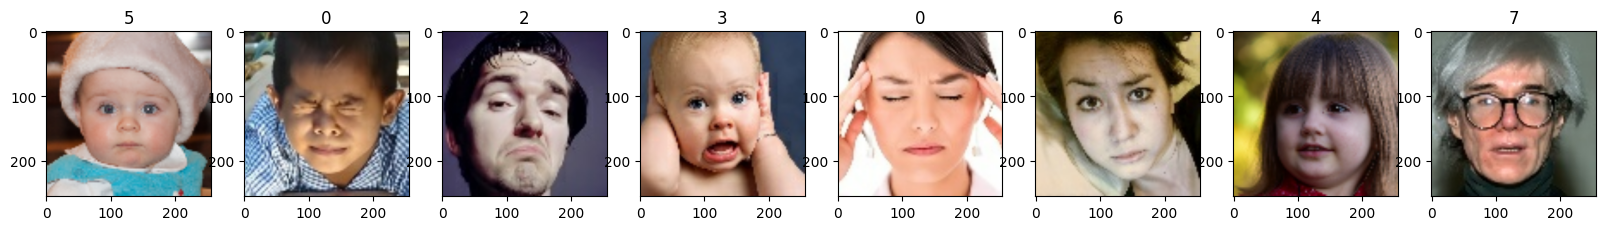

In [13]:
#To check the batch
fig, ax = plt.subplots(ncols=8, figsize=(20,20))
for idx, img in enumerate(batch[0][:8]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [14]:
batch = data_iterator.next()
batch[1]
#Images = batch[0] #Labels = bath[1]

array([1, 7, 2, 1, 7, 4, 4, 2, 4, 6, 6, 0, 3, 0, 6, 6, 4, 7, 3, 5, 2, 7,
       5, 1, 2, 2, 1, 5, 4, 5, 0, 0])

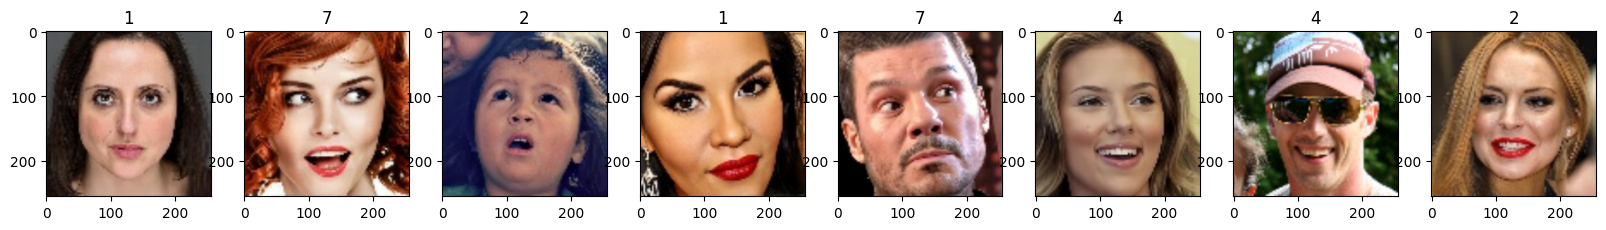

In [15]:
fig, ax = plt.subplots(ncols=8, figsize=(20,20))
for idx, img in enumerate(batch[0][:8]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

Preprocessing Data (Scaling,spliting between train,test)

In [16]:
print(batch[0].min())
print(batch[0].max())

0.0
255.0


In [17]:
scaled = batch[0]/255
print(scaled[0].min())
print(scaled[0].max())

0.0
0.9944853


Scaling all the data at one time while loading from pipeline instead of doing it in batches

In [18]:
data=data.map(lambda x,y:(x/255,y))

In [19]:
data.as_numpy_iterator().next()

(array([[[[0.14901961, 0.21960784, 0.19215687],
          [0.15      , 0.22058824, 0.19264705],
          [0.15588236, 0.22647059, 0.19558823],
          ...,
          [0.51029414, 0.53431374, 0.43480393],
          [0.5132353 , 0.54019606, 0.43186274],
          [0.5137255 , 0.5411765 , 0.43137255]],
 
         [[0.1487745 , 0.21887255, 0.19142157],
          [0.14977022, 0.21988358, 0.19197305],
          [0.15574448, 0.22594975, 0.19528186],
          ...,
          [0.53253675, 0.563174  , 0.46953124],
          [0.5351103 , 0.56868875, 0.4668658 ],
          [0.5355392 , 0.56960785, 0.46642157]],
 
         [[0.14730392, 0.21446079, 0.1870098 ],
          [0.14839154, 0.21565564, 0.18792892],
          [0.15491728, 0.22282475, 0.19344363],
          ...,
          [0.6659926 , 0.7363358 , 0.67789525],
          [0.6663603 , 0.7396446 , 0.6768842 ],
          [0.6664216 , 0.74019605, 0.6767157 ]],
 
         ...,
 
         [[0.59044117, 0.7120098 , 0.88848037],
          [0.59103

Spliting Test train 


In [20]:
#Total 908 batches and 32 images each ie; 32*908 = 29056
len(data)

908

In [21]:
traing_size = int(len(data)*.7)
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)+1

print(traing_size)
print(val_size)
print(test_size)
print(traing_size+val_size+test_size)

635
182
91
908


Take and skip method within tensorflow to split 

In [22]:
train=data.take(traing_size)
val=data.take(traing_size).take(val_size)
test = data.skip(traing_size+val_size).take(test_size)

In [23]:
len(test)

91

Creating CNN model

Building Deep learning model


In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [25]:
#MaxPooling2D??

In [26]:
model = Sequential()

model.add(Conv2D(64, (3,3), 1, activation='relu', input_shape=(256,256,3)))#Convolution layer 1
model.add(MaxPooling2D())#Pooling layer 1

model.add(Conv2D(32, (3,3), 1, activation='relu'))#Convolution layer 2
model.add(MaxPooling2D())#Pooling layer 2

model.add(Conv2D(16, (3,3), 1, activation='relu'))#Convolution layer 3
model.add(MaxPooling2D())#Pooling layer 3

model.add(Flatten())#Fully Connected layer

model.add(Dense(256, activation='relu'))
model.add(Dense(8, activation='softmax'))#Output layer

In [27]:
from keras import metrics

model.compile(loss='mean_squared_error', optimizer='sgd',
              metrics=[metrics.mae,
                       metrics.categorical_accuracy])


In [28]:
#model.compile('sgd', loss=tf.losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

Visualize CNN model

In [30]:
import visualkeras
visualkeras.layered_view(model).show() # display using your system viewer
visualkeras.layered_view(model, to_file='Neural_Network_Visualize.png') # write to disk
visualkeras.layered_view(model, to_file='Neural_Network_Visualize.png').show() # write and show

Train

In [31]:
logdir='logs'

In [32]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [33]:
Log_history = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10


635/635 [==============================] - 840s 1s/step - loss: 12.6843 - mean_absolute_error: 3.0073 - categorical_accuracy: 1.0000 - val_loss: 12.5046 - val_mean_absolute_error: 2.9741 - val_categorical_accuracy: 1.0000
Epoch 2/10
635/635 [==============================] - 821s 1s/step - loss: 12.6775 - mean_absolute_error: 3.0061 - categorical_accuracy: 1.0000 - val_loss: 12.4914 - val_mean_absolute_error: 2.9694 - val_categorical_accuracy: 1.0000
Epoch 3/10
635/635 [==============================] - 791s 1s/step - loss: 12.6798 - mean_absolute_error: 3.0062 - categorical_accuracy: 1.0000 - val_loss: 12.4390 - val_mean_absolute_error: 2.9627 - val_categorical_accuracy: 1.0000
Epoch 4/10
635/635 [==============================] - 788s 1s/step - loss: 12.6733 - mean_absolute_error: 3.0057 - categorical_accuracy: 1.0000 - val_loss: 12.4440 - val_mean_absolute_error: 2.9622 - val_categorical_accuracy: 1.0000
Epoch 5/10
635/635 [==============================] - 37679s 59s/step - loss: 1

Performance

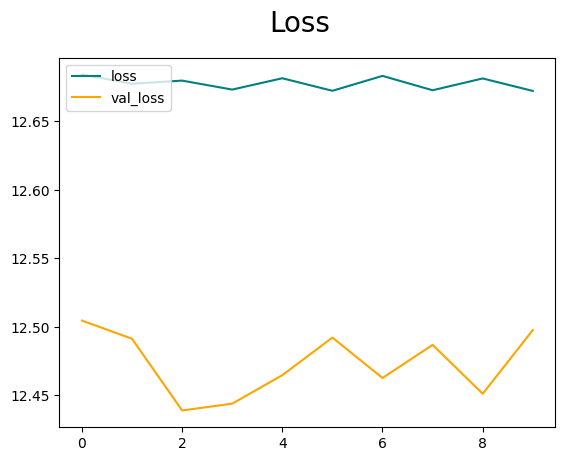

In [34]:
fig = plt.figure()
plt.plot(Log_history.history['loss'], color='teal', label='loss')
plt.plot(Log_history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

KeyError: 'val_accuracy'

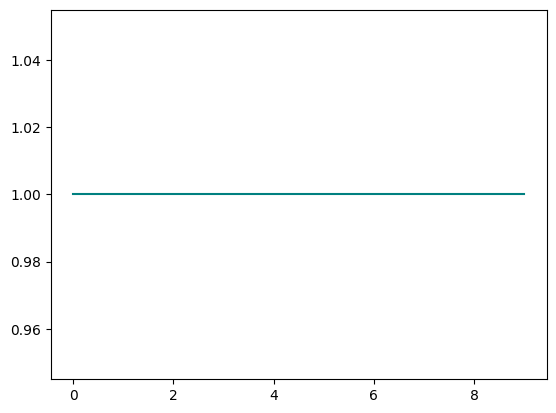

In [36]:
fig = plt.figure()
plt.plot(Log_history.history['categorical_accuracy'], color='teal', label='accuracy')
plt.plot(Log_history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

Evaluate performance

In [37]:
from tensorflow.keras.metrics import Precision, Recall,BinaryAccuracy,categorical_accuracy

In [38]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()
cat_acc = categorical_accuracy

In [46]:
X,y =batch
yhat=model.predict(X)
print(cat_acc(y,yhat))

1/1 [==============================] - 0s 133ms/step
tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(18,), dtype=float32)


In [41]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)
    cat_acc(y, yhat)

1/1 [==============================] - 0s 167ms/step


In [45]:
type(cat_acc)

function

In [44]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy : {acc.result().numpy()},Categorical_Accuracy : {cat_acc}')

Precision:0.8815699815750122, Recall:1.0, Accuracy : 0.09351535886526108,Categorical_Accuracy : <function categorical_accuracy at 0x0000024DF4BB1260>


Test

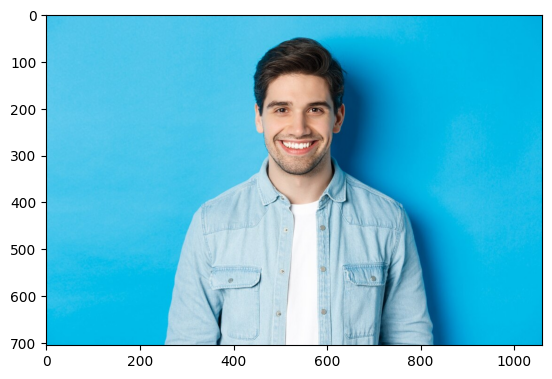

In [54]:
img = cv2.imread('test/happy.jpg')
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()

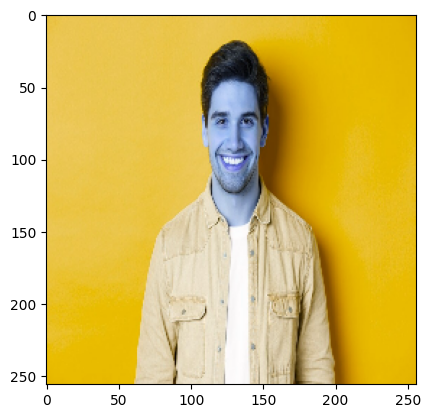

In [55]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [56]:
import numpy as np

In [57]:
resize.shape

TensorShape([256, 256, 3])

In [58]:
np.expand_dims(resize,0).shape

(1, 256, 256, 3)

In [59]:

yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 36ms/step


In [60]:

yhat

array([[1.]], dtype=float32)

In [ ]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Happy


Save the model

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model.save(os.path.join('models','emotion_cnn.h5'))

C:\Users\Biswaji Deb\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
new_model = load_model(os.path.join('models','emotion_cnn.h5'))

In [ ]:
new_model.predict(np.expand_dims(resize/255,0))

1/1 [==============================] - 0s 77ms/step


array([[nan]], dtype=float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


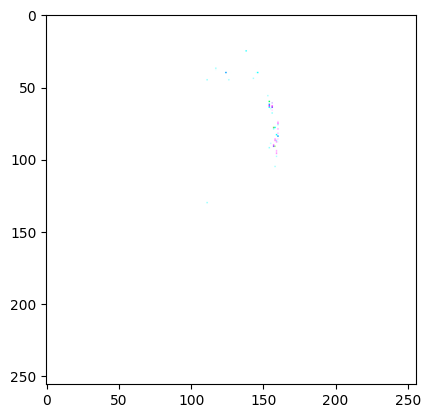

In [ ]:
plt.imshow(resize)